# 4. Network graphs

Graphs may not be the most aesthetic visualizations, but they too can tell a story. For example, graphs are perfect to show the interactions between different items. Multiplex's graph visualizations help you not just plot graphs, but also explain them.

Sometimes called networks, graphs are made up of nodes. Nodes can be connected with each other using edges, which can be both directed and undirected. Multiplex's graph visualization is designed to help you get started with creating network graphs very easily.

In this notebook, we will go through an example of creating a network representing the Marvel Universe's superheroes. Although in this notebook we create an undirected network, Multiplex also supports directed graphs. 

Without further ado, it's time for a super visualization!

> Multiplex partially uses `networkx` to draw graphs, which means that the package has to be installed to draw network graphs. You can learn more about `networkx` [here](https://networkx.github.io/).

In [1]:
%load_ext autoreload
%autoreload 2

import importlib
import matplotlib.pyplot as plt
from networkx import edge_betweenness_centrality
from networkx.algorithms import centrality, community, shortest_paths
import networkx as nx
import os
import pandas as pd
import re
import sys

path = sys.path[0]
path = os.path.join(path, "..")
if path not in sys.path:
    sys.path.insert(1, path)

Even superheros have friends. The running example uses the [Marvel Universe Social Network](https://www.kaggle.com/csanhueza/the-marvel-universe-social-network) dataset to map out the relationships between superheroes.

This dataset is made up of pairs of superheroes that appeared together in the same comic. Unfortunately, it is _huge_ so we filter out superhero connections that do not appear at least 50 times together. That still leaves us with plenty of data.

In [2]:
# load the data
df = pd.read_csv('data/the-marvel-universe-social-network/hero-network.csv')
df.columns = ('source', 'target')
df = df.groupby(['source', 'target']).size().reset_index()
df.columns = ('source', 'target', 'frequency')

# filter the data to remove connections between superheroes that appeared less than 50 times together
df = df[df['frequency'] >= 50]
df = df[df['source'] != df['target']]
df.sort_values(by='frequency', ascending=False)

,source,target,frequency
142513,PATRIOT/JEFF MACE,MISS AMERICA/MADELIN,1267
124772,MISS AMERICA/MADELIN,PATRIOT/JEFF MACE,627
196026,THING/BENJAMIN J. GR,HUMAN TORCH/JOHNNY S,382
85445,HUMAN TORCH/JOHNNY S,MR. FANTASTIC/REED R,366
196250,THING/BENJAMIN J. GR,MR. FANTASTIC/REED R,365
...,...,...,...
161485,ROGUE /,SHADOWCAT/KATHERINE,50
77385,HAWK,BLACK WIDOW/NATASHA,50
78713,HEIMDALL [ASGARDIAN],THOR/DR. DONALD BLAK,50
82469,HOGUN [ASGARDIAN],LOKI [ASGARDIAN],50


Multiplex draws networks from `networkx` graphs. Therefore before drawing the Marvel Universe superhero network, we convert the data into a graph. If you have never used `networkx`, worry not. It is extremely simple to create graphs from nodes or edges.

For the sake of the example, we make the dataset smaller by focusing on the 50 most popular superheroes in the dataset.

In [3]:
# convert the data into a networkx graph
G = nx.convert_matrix.from_pandas_edgelist(df, 'source', 'target')

# retain only the 50 most popular superheroes
degree = sorted(G.degree(), key=lambda hero: hero[1], reverse=True)
top = [ hero for hero, neighbours in degree if neighbours > 2 ][:50]
G = G.subgraph(top)

print(f"{ len(G.nodes) } nodes, { len(G.edges) } edges")

50 nodes, 237 edges


As soon as we create the graph, plotting it is as simple as calling the drawable's `draw_graph` function.

`k` and `seed` are `networkx` parameters that control what the graph looks like; `k` is how tight the graph is and `seed` allows us to experiment with the style without having nodes moving around.

Everything else is `matplotlib` functionality. We use `s` to control the node size. We pass the node and edge styling separately as dictionaries using the `node_style` and `edge_style` parameters.

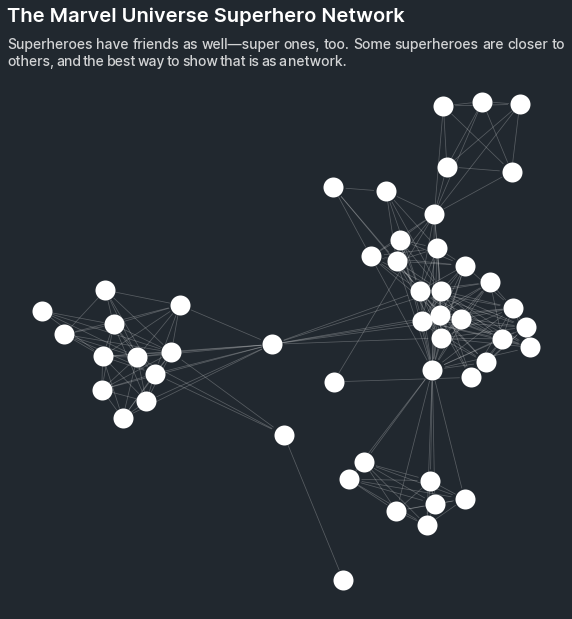

In [4]:
# import the Drawable class and set the style
from multiplex import drawable
drawable = importlib.reload(drawable)
plt.style.use(os.path.join(sys.path[0], '..', 'styles', "multiplex-dark.style"))

# create a general style
node_style = { 's': 400, 'color': 'C0', 'linewidth': 0 }
edge_style = { 'color': 'C0', 'linewidth': 0.75, 'alpha': 0.25 }

# draw the graph
figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption("""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.""",
                align='justify')

viz.draw_graph(G, k=0.6, seed=12,
               node_style=node_style, edge_style=edge_style)
viz.show()

That was easy, wasn't it? With just a few lines of code, we converted the superhero data into a network, defined the style and plotted it as a visualization.

The visualization, although rudimentary, already shows that some superheroes are closer than others. However, there are no names and readers come away none the wiser. Let's change that, then!

One interesting experiment is to find out the biggest cluster of superheroes. Before drawing the next network, we define a function to find the most central edge, and use it to partition the graph.

In [5]:
def most_central_edge(G):
    """
    Find the most central edge in the given graph.
    
    :param G: The graph on which the algorithm operates.
    :type G: :class:`networkx.Graph`
    
    :return: The most central edge, made up of the source and edge nodes.
    :rtype: tuple
    """

    centrality = edge_betweenness_centrality(G)
    return max(centrality, key=centrality.get)
    
"""
Keep looking for communities until we break it down into 20 or more partitions.
"""
communities = community.girvan_newman(G, most_valuable_edge=most_central_edge)
partitions = list(next(communities))
while len(partitions) < 20:
    partitions = list(next(communities))

"""
Remove partitions with one node and print the largest partition.
"""
partitions = [ partition for partition in partitions if len(partition) > 1 ]
partitions = sorted(partitions, key=len, reverse=True)
print(f"Largest partition: { ', '.join(superhero.strip().title() for superhero in partitions[0]) }")

Largest partition: Black Panther/T'Chal, Ant-Man/Dr. Henry J., Iron Man/Tony Stark, Jarvis, Edwin, Quicksilver/Pietro M, Captain America, Hawk, Scarlet Witch/Wanda, Wasp/Janet Van Dyne, Vision, Wonder Man/Simon Wil, Thor/Dr. Donald Blak


Unsurprisingly, the largest group of superheroes is The Avengers. With Multiplex, we can style them to make the popular superheroes pop out. That's what we'll do next: we color The Avengers and their connections red.

Remember that styling options are passed on using the `node_style` and `edge_style` parameters, which we defined above. However, we can still override them. This can be done by updating the graph itself, assigning a `style` to nodes and edges. Attributes defined there gain precidence over the general node and edge styles.

We also add a `label` attribute to The Avenger nodes, which automatically creates a legend. The `label` attribute can also be added to edges.

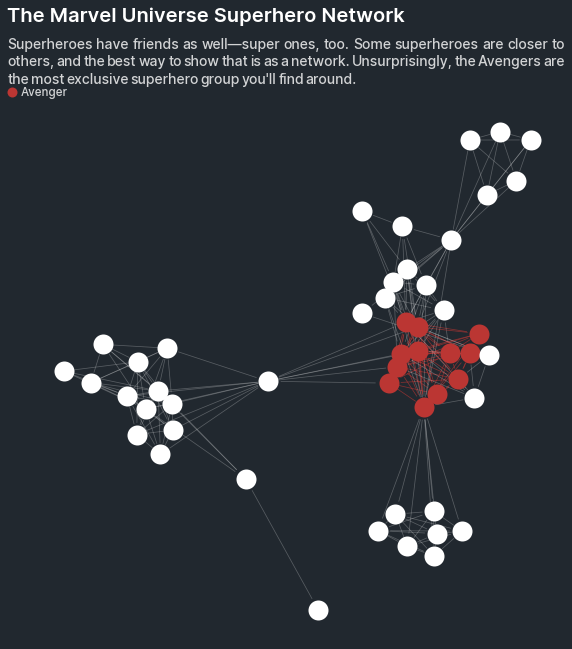

In [6]:
# reload the style
plt.style.use(os.path.join(sys.path[0], '..', 'styles', "multiplex-dark.style"))

# add a specific style to The Avenger nodes and edges between them
avengers = partitions[0]
for node in avengers:
    G.nodes[node]['style'] = { 'color': '#BB3633', 'edgecolor': 'C0' }
    G.nodes[node]['label'] = 'Avenger'
    edges = [ (source, target) for (source, target) in G.edges(node)
             if target in avengers ]
    for edge in edges:
        G.edges[edge]['style'] = { 'alpha': 0.65, 'color': '#BB3633' }

# draw the graph
figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption("""Superheroes have friends as well—super ones, too.
                   Some superheroes are closer to others, and the best way to show that is as a network.
                   Unsurprisingly, the Avengers are the most exclusive superhero group you'll find around.""",
                align='justify')

viz.draw_graph(G, k=0.5, seed=12,
               node_style=node_style, edge_style=edge_style)
viz.show()

That's better, isn't it? However, we still don't know who The Avengers are. To answer this question, in the next visualization we use centrality to elect a leader.

In [7]:
# isolate The Avengers and find the most central member
S = G.subgraph(partitions[0])
node_centrality = centrality.eigenvector_centrality(S)
leader = max(node_centrality, key=node_centrality.get)
print(f"Most central Avenger: { leader.title() }")

Most central Avenger: Ant-Man/Dr. Henry J.


Now that we know who the leader is, we can show their name on the graph by using the `name` attribute. To change how the name looks like, use the `name_style` attribute. Although we only use these attributes for nodes, we can do the same for edges.

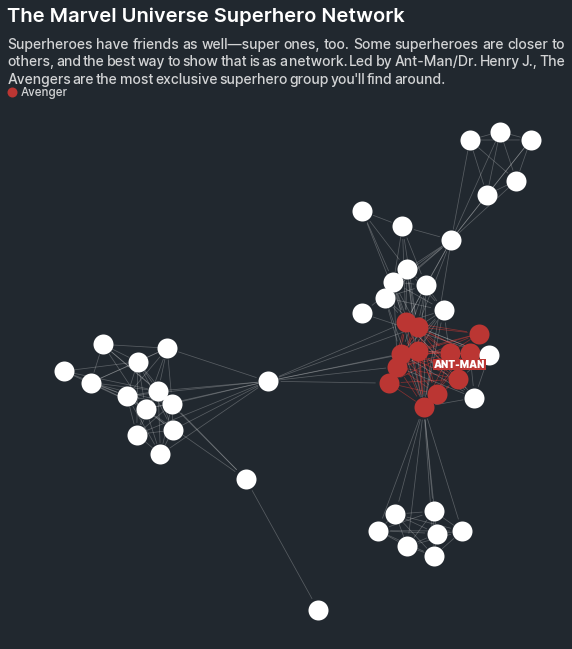

In [8]:
# reload the style
plt.style.use(os.path.join(sys.path[0], '..', 'styles', "multiplex-dark.style"))

# give The Avengers' leader a name
pattern = re.compile('^(.+)?[,\/\[].+?$')
G.nodes[leader]['name'] = pattern.findall(leader)[0] if pattern.findall(leader) else leader
G.nodes[leader]['name_style'] = { 'facecolor': '#BB3633', 'color': 'C0', 'lineheight': 1,
                                  'fontsize': 10, 'fontweight': 900 }

# draw the graph
figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption(f"""Superheroes have friends as well—super ones, too.
                    Some superheroes are closer to others, and the best way to show that is as a network.
                    Led by { leader.title() }, The Avengers are the most exclusive superhero group you'll find around.""",
                align='justify')

viz.draw_graph(G, k=0.5, seed=12,
               node_style=node_style, edge_style=edge_style)
viz.show()

Now the network is starting to tell a story. The last change we make to it is by diminishing the importance of nodes based on how far they are from The Avengers. The way that we do this is by calculating a distance measure, making nodes smaller if they are far away from The Avengers' leader.

In [9]:
# calculate the distance from the leader to every other node
distances = { node: len(shortest_paths.generic.shortest_path(G, leader, node))
              for node in G.nodes }
distances[leader] = 0

Having calculated the distances from the leader, we make nodes smaller the farther away they are from The Avengers.

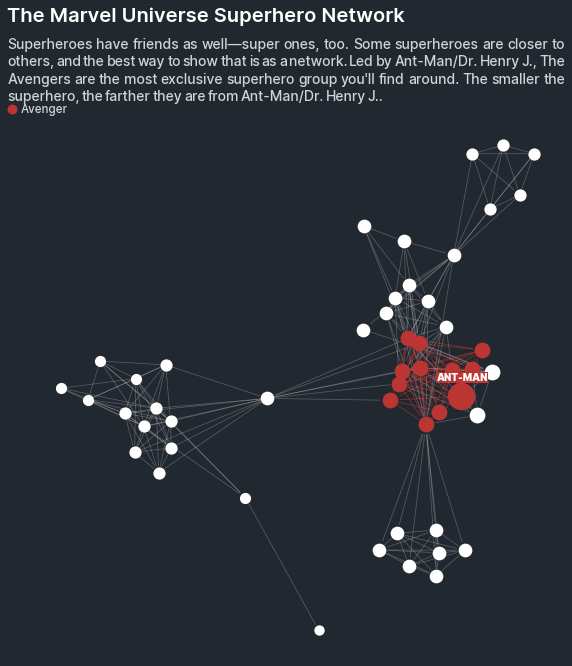

In [10]:
# reload the style
drawable = importlib.reload(drawable)
plt.style.use(os.path.join(sys.path[0], '..', 'styles', "multiplex-dark.style"))

# calculate a size for the nodes depending on their distance from The Avengers
for node in G.nodes:
    G.nodes[node]['style'] = G.nodes[node].get('style', { })
    G.nodes[node]['style']['s'] = 750 / (distances[node] + 1)

# draw the graph
figure = plt.figure(figsize=(10, 10))
viz = drawable.Drawable(figure)
viz.set_title('The Marvel Universe Superhero Network', loc='left')
viz.set_caption(f"""Superheroes have friends as well—super ones, too.
                    Some superheroes are closer to others, and the best way to show that is as a network.
                    Led by { leader.title() }, The Avengers are the most exclusive superhero group you'll find around.
                    The smaller the superhero, the farther they are from { leader.title() }.""",
                 align='justify')

viz.draw_graph(G, k=0.5, seed=12,
               node_style=node_style, edge_style=edge_style)

viz.savefig('exports/4-marvel.png', dpi=300, bbox_inches='tight')

You can learn more about graph visualizations, including functionality that was not covered in this tutorial, on [Multiplex's documentation site](https://nicholasmamo.github.io/multiplex-plot/graph.html). You can continue learning about Multiplex in the [bar charts tutorial](https://github.com/NicholasMamo/multiplex-plot/blob/master/examples/5.%20Bar%20charts.ipynb).